In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

## nb: getting nc_time_axis and esmlab to load on cheyenne required following the instructions under the heading "Creating your own clone of the NCAR Package Library" here: https://www2.cisl.ucar.edu/resources/python-–-ncar-package-library
## which thus meant: ncar_pylib -c 20190627 /glade/work/$USER/my_npl_clone
## ncar_pylib -c 20190627 /glade/work/$USER/my_npl_clone
## and subsequently
## ncar_pylib my_npl_clone
## pip install nc-time-axis
## pip install esmlab

In [2]:
#casename = 'fates_clm50_global_4x5_historicaltransient_nofire_2e3f469f_5e6fa21f'
casename = 'fates_clm50_global_4x5_historicaltransient_2e3f469f_2905a9ba'

datadir = '/glade/scratch/charlie/archive/'+casename+'/lnd/hist/'

### preprocess the history file using ncrcat because xr.open_mfdataset is too damn slow
merged_filename = datadir+casename+'.sofar.nc'

landuse_filename = '/glade/u/home/charlie/scratch/landuse.timeseries_4x5_hist_16pfts_Irrig_CMIP6_simyr1850-2015_c190214_cdkmod_areaharvest_c200622.nc'

surfdata_filename = '/glade/p/cesmdata/cseg/inputdata/lnd/clm2/surfdata_map/release-clm5.0.18/surfdata_4x5_hist_16pfts_Irrig_CMIP6_simyr1850_c190214.nc'

In [3]:
data_in = xr.open_dataset(merged_filename)

landuse_file = xr.open_dataset(landuse_filename)

surfdata_file = xr.open_dataset(surfdata_filename)

In [4]:
ntim = len(data_in.variables['time'])
IM = len(data_in.variables['lon'])
JM = len(data_in.variables['lat'])

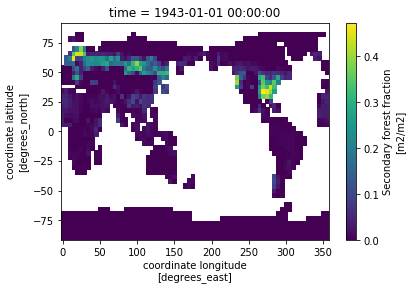

In [5]:
### plot secodnary forest fraction at end of run
data_in.SECONDARY_FOREST_FRACTION.isel(time=ntim-1).plot()

/glade/work/charlie/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


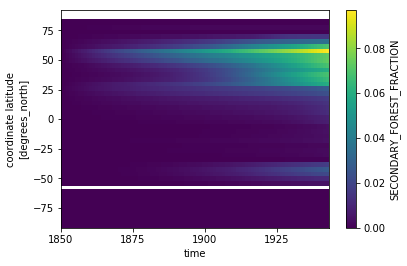

In [6]:
### plot secodnary forest fraction zonal mean over time

data_in.SECONDARY_FOREST_FRACTION.mean(dim='lon').plot(x='time', y='lat')

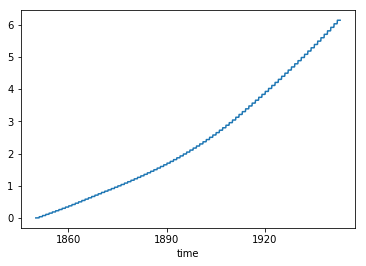

In [7]:
## plot timeseries of secondary forest area in million square km
(data_in.area * data_in.SECONDARY_FOREST_FRACTION * 1e-6).sum(dim='lat').sum(dim='lon').plot()

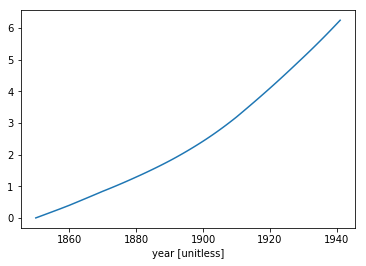

In [8]:
## plot accumated logged area in million square km from forcing dataset

## need to normalize this by the fraction of a gridcell that FATES occupies.  
### two options of how to do this:

#option 1, use surface data file variables to reconstruct
#frac_fates = 1. - (surfdata_file.PCT_WETLAND + surfdata_file.PCT_GLACIER + surfdata_file.PCT_LAKE + surfdata_file.PCT_URBAN.sum(dim='numurbl')) * 1.e-2

# option 2, diagnose it from the FATES history file itself.  one way to do so is that the sum of PATCH_AREA_BY_AGE must equal 1, so we can use that to infer the FATES fraction
frac_fates = data_in.PATCH_AREA_BY_AGE.sum(dim='fates_levage').isel(time=0).values

primary_harvest_input = (landuse_file.HARVEST_VH1 + landuse_file.HARVEST_VH2) * landuse_file.AREA * 1e-6 * frac_fates
primary_harvest_input.sum(dim='lsmlon').sum(dim='lsmlat').cumsum(dim='time').isel(time=slice(0,int(ntim/12)-1)).plot()

In [9]:
### check to see if the fates gridcell fraction is correct.
## skipping this for now as I'm just using the other data

#plt.plot(frac_fates.values.flatten(), data_in.PATCH_AREA_BY_AGE.sum(dim='fates_levage').isel(time=0).values.flatten(), '.') 
#plt.xlabel('land surface file fraction')
#plt.ylabel('fates history file fraction')

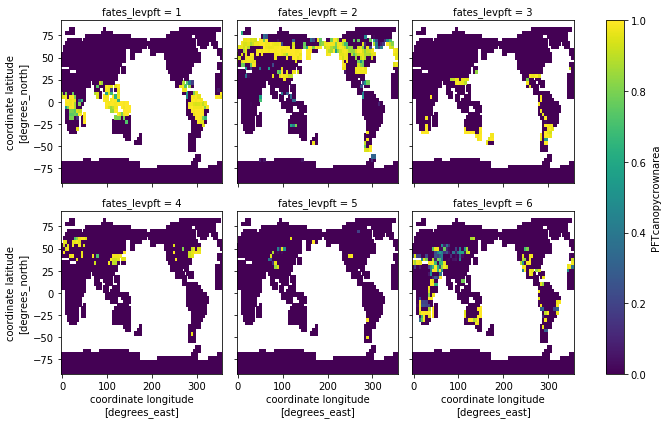

In [10]:
### plot canopy coverage of each PFT at start of run

(data_in.PFTcanopycrownarea.isel(time=0)*1e-4).plot(x='lon',y='lat',col='fates_levpft', col_wrap=3)

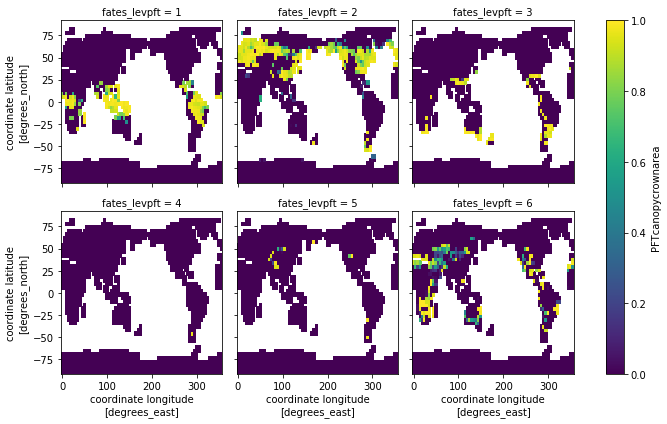

In [11]:
### plot canopy coverage of each PFT at end of run

(data_in.PFTcanopycrownarea.isel(time=ntim-1)*1e-4).plot(x='lon',y='lat',col='fates_levpft', col_wrap=3)

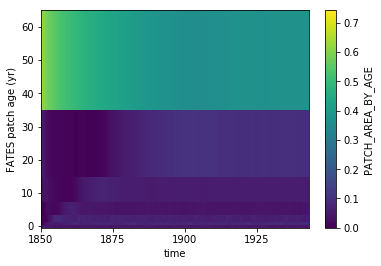

In [12]:
data_in.PATCH_AREA_BY_AGE.mean(dim='lon').mean(dim='lat').plot(x='time', y='fates_levage')

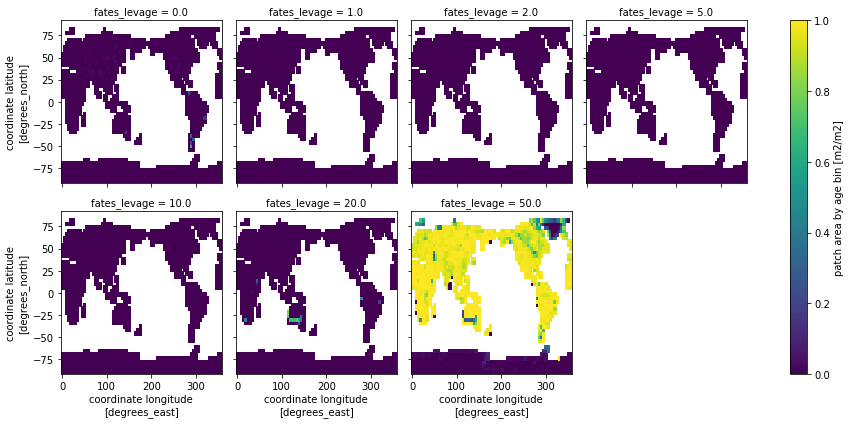

In [13]:
data_in.PATCH_AREA_BY_AGE.isel(time=0).plot(x='lon',y='lat',col='fates_levage', col_wrap=4)

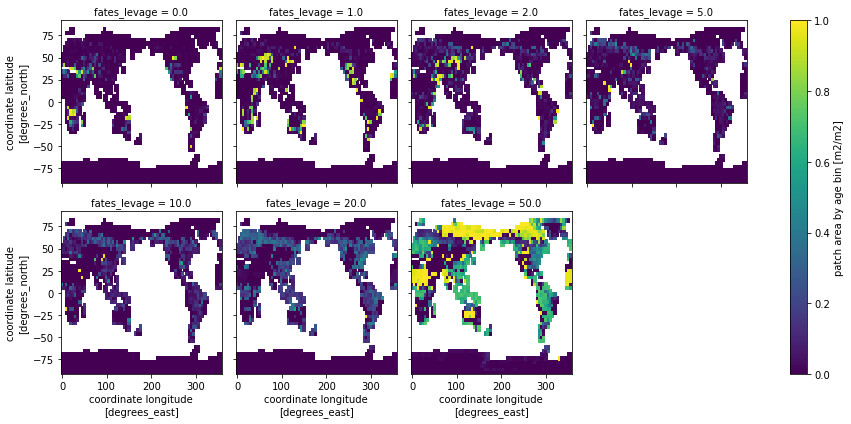

In [14]:
data_in.PATCH_AREA_BY_AGE.isel(time=ntim-1).plot(x='lon',y='lat',col='fates_levage', col_wrap=4)

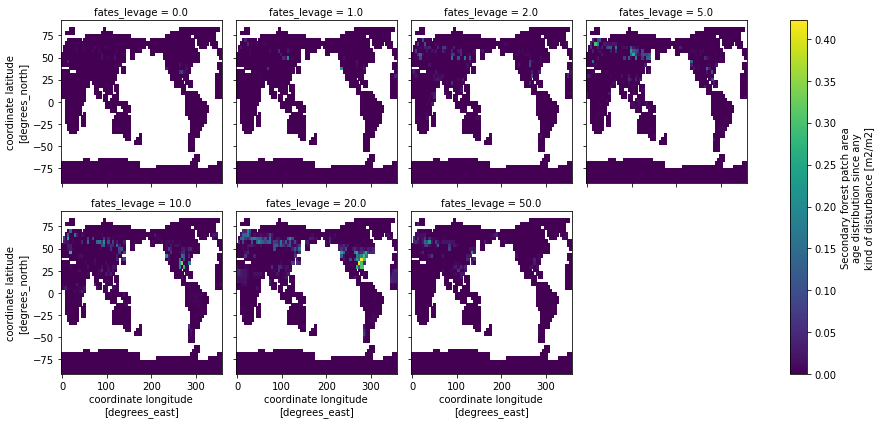

In [15]:
data_in.SECONDARY_AREA_PATCH_AGE_DIST.isel(time=ntim-1).plot(x='lon',y='lat',col='fates_levage', col_wrap=4)

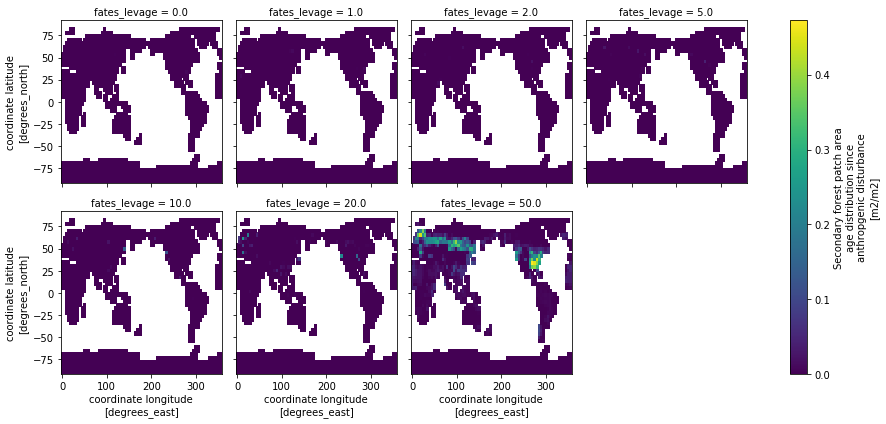

In [16]:
data_in.SECONDARY_AREA_AGE_ANTHRO_DIST.isel(time=ntim-1).plot(x='lon',y='lat',col='fates_levage', col_wrap=4)

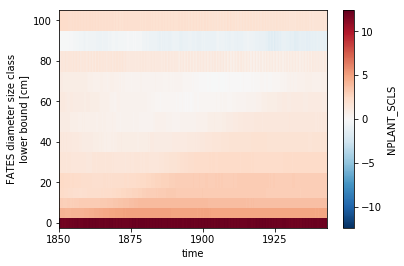

In [17]:
np.log(data_in.NPLANT_SCLS.mean(dim='lon').mean(dim='lat')).plot(x='time', y='fates_levscls')

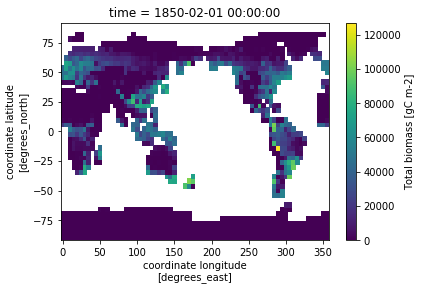

In [18]:
data_in.ED_biomass.isel(time=0).plot()

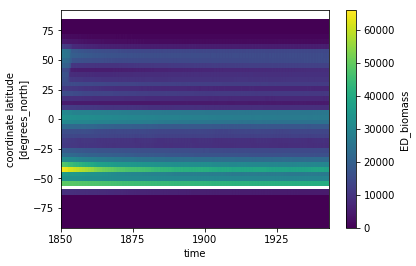

In [19]:
data_in.ED_biomass.mean(dim='lon').plot(x='time', y='lat')

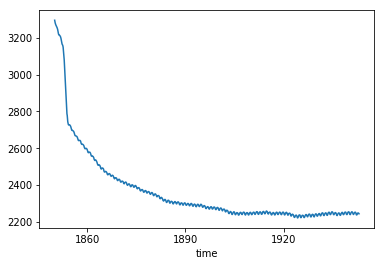

In [20]:
(data_in.area * data_in.ED_biomass * 1e6 * 1e-15).sum(dim='lon').sum(dim='lat').plot(x='time')

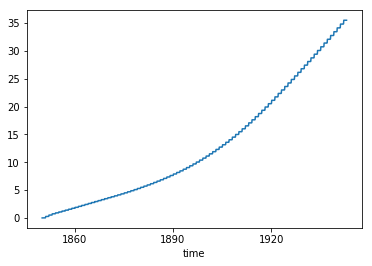

In [21]:
## plot timeseries of logged wood in Pg C
(data_in.area * data_in.WOOD_PRODUCT * 1e6*1e-15).sum(dim='lat').sum(dim='lon').plot()

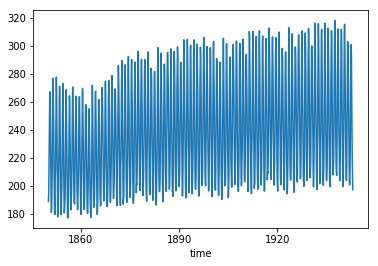

In [22]:
(data_in.area * data_in.GPP * 86400*365*1e-15*1e6).sum(dim='lon').sum(dim='lat').plot(x='time')

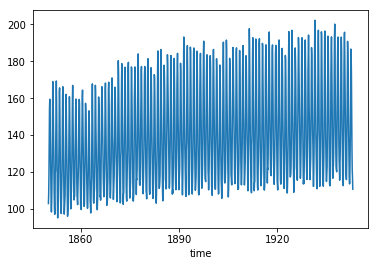

In [23]:
(data_in.area * data_in.NPP * 86400*365*1e-15*1e6).sum(dim='lon').sum(dim='lat').plot(x='time')